The following code was written by Andrew Bailey and Trevor Pesout. We both contributed equally. 

In [1]:
#!/usr/bin/env python
"""Module Docstrings"""
########################################################################
# File: template.py
#  executable: template.py
#
# Author: Andrew Bailey/ Trevor Pesout
# History: Created 10/18/17
########################################################################

from __future__ import print_function
import sys
from timeit import default_timer as timer
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import numpy as np
import math
from scipy.special import expit


def sigmoid(x, alpha=1, beta=0):
    """Sigmoid function"""

    # this can overflow a double, so we use different implementations
    # return math.exp(alpha*(x+beta)) / (1 + math.exp(alpha*(x+beta)))
    if x < 0:
        return 1 - 1 / (1 + math.exp(alpha*(x+beta)))
    else:
        return 1 / (1 + math.exp(-alpha*(x+beta)))



def integral_of_sigmoid(x):
    """Returns the value from the integral of the sigmoid function"""
    return np.log((1+np.exp(x)))


def iterative_reweighted_least_squares(inputs, labels, weights):
    """Newton-Raphson iterative reweighted least squares"""


def logistic_hessian(inputs, weights):
    """Calculate hessian matrix for logistic regression"""
    y_hat = logistic_evaluation(inputs, weights)
    b = np.array([1-y for y in y_hat])
    # p(1-p)

    prob = [y_hat*b]
    n = len(prob[0])
    assert n == len(y_hat)
    d = np.repeat(prob, [n,], axis=0)
    I = np.identity(n)
    R = np.multiply(I, prob)
    # hessian = np.matmul(np.matmul(inputs.T, R), inputs)
    return R

def read_spam_data(csv_f):
    """Read in csv of ham spam data and return two lists of data"""
    label = []
    message = []
    with open(csv_f) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            message.append(row['sms'])
            label.append(row['label'])
            # print(row['label'], row['sms'])
    return message, label

# we want to make this use the same features with different data (so we can test)
def create_train_data(corpus, stop_words, bigram=False, lowercase=True):
    """Extract features from corpus and perform the tf-idf term weighting as well as removing stopwords"""
    # option to have 'this word' as a feature along with 'this' and 'word'
    if bigram:
        vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b',
                                     min_df=1, decode_error='ignore', stop_words=stop_words,
                                     lowercase=lowercase)
    else:
        vectorizer = CountVectorizer(decode_error='ignore', stop_words=stop_words, lowercase=lowercase)

    # create feature vector
    X = vectorizer.fit_transform(corpus)
    transformer = TfidfTransformer(smooth_idf=False, norm='l2')
    # normalize and perform tf-idf
    tfidf = transformer.fit_transform(X)
    return tfidf.toarray(), vectorizer


def create_spam_ham_labels(labels_text, spam=1, ham=0):
    """Convert spam and ham into either 0 or 1 """
    integer_labels = []
    for label in labels_text:
        if label == "spam":
            integer_labels.append(spam)
        else:
            assert label == "ham"
            integer_labels.append(ham)
    return integer_labels


def square_loss(features, labels, weights):
    """Calculates total loss of lists of features and labels given weights"""
    total_loss = 0
    for index, feature in enumerate(features):
        a = sigmoid(np.matmul(weights, feature.T))
        total_loss += ((a-labels[index])**2) / 2.0
    return total_loss / len(labels)


def logistic_loss(features, labels, weights):
    """Calculates total loss of lists of features and labels given weights"""
    total_loss = 0
    for index, feature in enumerate(features):
        y = labels[index]
        a = np.matmul(weights, feature.T)
        y_hat = sigmoid(a)
        if y_hat == 0:
            print("ERROR its 0")
        # need to double check this equation
        total_loss += y*np.log(y) + (1-y)*np.log(1-y_hat)
    return total_loss


def logistic_evaluation(inputs, weights):
    """Returns predicted outputs from the inputs and weights"""
    prediction = []
    for index, feature in enumerate(inputs):
        a = np.matmul(weights, feature.T)
        y_hat = sigmoid(a)
        prediction.append(y_hat)
    return np.array(prediction)


def logistic_regression(inputs, labels, weights, l, alpha, eta_0, step):
    """Implement regularized logistic regression with moving learning weight"""
    eta = eta_0*(step**alpha)
    y_hat = logistic_evaluation(inputs, weights)
    new_weights = weights*(1-(eta*l)) - (eta*np.matmul(np.array(y_hat-labels), inputs))
    return new_weights


In [2]:
########################################################
# prepare and load the training data.  this involves
# reading in the data and finding the best features
########################################################

# if cant find stopwords you can download using this:
# import nltk
# nltk.download('stopwords')

# init
stop_words = stopwords.words('english')
train_data = 'train.csv'
# test_data = 'test.csv'

# interpret data
messages, text_labels = read_spam_data(train_data)
all_train_data, train_vectorizer = create_train_data(messages, stop_words)
int_labels = create_spam_ham_labels(text_labels, spam=1, ham=0)

# get sizes
n_messages = len(messages)
n_features = all_train_data.shape[1]
# make sure everything is still aligned
print(all_train_data.shape)
assert all_train_data.shape[0] == len(messages)
assert all_train_data.shape[0] == len(int_labels)
assert all_train_data.shape[0] == len(text_labels)

(3000, 6179)


In [3]:
########################################################
# this is the definition of the hyper parameters for
# the regression
########################################################

# lambda
lambda_base = 4 #8 #np.e
lambda_exp_min = -6 #-5
lambda_exp_max = 1 #1
list_of_lambdas = [lambda_base**i for i in range(lambda_exp_min,lambda_exp_max+1)] 
print("LAMBDAS:\n\tbase: {}   log_min: {}   log_max: {}\n\t{}".format( 
      lambda_base, lambda_exp_min, lambda_exp_max, list_of_lambdas))

# sigmoid params
eta_0 = 0.1
alpha = 0.9

LAMBDAS:
	base: 4   log_min: -6   log_max: 1
	[0.000244140625, 0.0009765625, 0.00390625, 0.015625, 0.0625, 0.25, 1, 4]


In [5]:
########################################################
# divide the data for 10-fold cross validation
########################################################

# identifiers
TRAIN_DATA = "t_data"
TRAIN_LABELS = "t_labels"
VALIDATE_DATA = "v_data"
VALIDATE_LABELS = "v_labels"

# prep
number_of_buckets = 10
size_of_bucket = int(n_messages / number_of_buckets)
all_train_buckets = dict()

# divide into buckets
idx = 0
for b in range(number_of_buckets):
    data = all_train_data[idx:idx+size_of_bucket]
    labels = int_labels[idx:idx+size_of_bucket]
    all_train_buckets[b] = [data, labels]
    idx += size_of_bucket
    
    
# how to create train and validation data sets
def get_train_data_set(idx):
    t_data, t_labels = list(), list()
    v_data, v_labels = None, None
    for k in all_train_buckets.keys():
        v = all_train_buckets[k]
        if k == idx:
            v_data = v[0]
            v_labels = v[1]
        else:
            t_data.append(v[0])
            t_labels.append(v[1])
    return {
        TRAIN_DATA: np.vstack(t_data), 
        TRAIN_LABELS: np.hstack(t_labels),  
        VALIDATE_DATA: v_data, 
        VALIDATE_LABELS: v_labels
    }

# get data
all_training_datasets = [get_train_data_set(x) for x in list(range(number_of_buckets))]

# validation
assert len(all_training_datasets) == number_of_buckets
for ds in all_training_datasets:
    assert ds[TRAIN_DATA].shape[1] == n_features
    assert ds[TRAIN_DATA].shape[0] == len(ds[TRAIN_LABELS])
    assert ds[VALIDATE_DATA].shape[1] == n_features
    assert ds[VALIDATE_DATA].shape[0] == len(ds[VALIDATE_LABELS])

In [5]:
########################################################
# definition of our regression function
########################################################


def run_regression(lamda, train, train_labels, validate, validate_labels, 
                   eta_0=0.1, alpha=0.9, iterations=321, verbose=False):
    # init
    report_frequency = int(iterations / 16.0)
    t = None
    
    #run regression
    try:
        weights = np.random.normal(0, 0.2, n_features)
        min_validate_loss = sys.maxsize
        min_train_loss = sys.maxsize
        best_weights = None
        for t in range(iterations):
            weights = logistic_regression(train, train_labels, weights, lamda, alpha, eta_0, t)
            train_loss = square_loss(train, train_labels, weights=weights)
            val_loss = square_loss(validate, validate_labels, weights=weights)
            if verbose and t % report_frequency == 0:
                print("{}:\t#{}\ttrain {}  \t\tvalidate {}".format(l, t, train_loss, val_loss))
            if train_loss < min_train_loss: 
                min_train_loss = train_loss
            if val_loss < min_validate_loss: 
                best_weights = weights
                min_validate_loss = val_loss
    except Exception as e:
        print("\nlambda {} #{}: {}".format(l, t, e), sys.stderr)
        import traceback
        traceback.print_exc()
        return False
    
    # return best
    return min_validate_loss, min_train_loss, best_weights

In [6]:
########################################################
# run on each of our k-folded datasets
########################################################

# prep
lambda_to_validate_errors = dict()
lambda_to_training_errors = dict()
lambda_to_weights = dict()

# calculate for our lambdas
for l in list_of_lambdas:
    start = timer()
    print("\nLAMBDA: {}\n\t".format(l),end='')
    v_errors = list()
    t_errors = list()
    all_weights = list()
    lambda_to_validate_errors[l] = v_errors
    lambda_to_training_errors[l] = t_errors
    lambda_to_weights[l] = all_weights
    for dataset in all_training_datasets:
        v_error, t_error, weights = run_regression(l, dataset[TRAIN_DATA], dataset[TRAIN_LABELS], 
                       dataset[VALIDATE_DATA], dataset[VALIDATE_LABELS])
        v_errors.append(v_error)
        t_errors.append(t_error)
        all_weights.append(weights)
        print('.', end='')
    print(" ({}s)".format(int(timer() - start)))
    print("\tv errors:    {}".format(v_errors))
    print("\tv error avg: {}".format(np.mean(v_errors)))
    print("\tv error std: {}".format(np.std(v_errors)))


LAMBDA: 0.000244140625
	.......... (357s)
	v errors:    [0.01205042179870902, 0.017946544821977037, 0.015083756891518361, 0.015080125864974097, 0.01733474456349715, 0.016445267105921195, 0.009715620735469504, 0.011323923592573549, 0.011118302090411293, 0.009042580495665219]
	v error avg: 0.013514128796071643
	v error std: 0.00307983600113283

LAMBDA: 0.0009765625
	.......... (356s)
	v errors:    [0.01208328563336651, 0.017672249518279736, 0.014833702497650562, 0.014816646858113847, 0.017559101487407094, 0.01632975184719122, 0.010078812367188736, 0.011536310545255453, 0.011045053976121025, 0.008957130375020779]
	v error avg: 0.013491204510559495
	v error std: 0.002993912477667525

LAMBDA: 0.00390625
	.......... (366s)
	v errors:    [0.012470719223168511, 0.017430335690091933, 0.014919897164791024, 0.0147432059895237, 0.017219226294959342, 0.014960532306876608, 0.010659936450595854, 0.010175532677848187, 0.009885602766859852, 0.008987132543981187]
	v error avg: 0.013145212110869619
	v e

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:138: RuntimeWarning: overflow encountered in multiply


.......... (351s)
	v errors:    [0.06289205017412895, 0.060758141074031234, 0.05915849649446896, 0.05775162675483218, 0.05952831488884558, 0.05970354871887933, 0.05333333333333334, 0.05691022963435813, 0.05820718013677701, 0.054182119968007106]
	v error avg: 0.05824250411776619
	v error std: 0.002741852502016953


In [23]:
########################################################
# print table of data
########################################################

size = 13
header = "| %{}s |%{}s |%{}s |%{}s |%{}s |%{}s |".format(size, size, size, size, size, size) % ("log_{}(lambda)".format(lambda_base), "lambda", "val error", "val stddev", "train error", "train stddev")
spacer = "+-" + ("-" * size) + "-+" + ("-" * size) + "-+" + ("-" * size) + "-+" + ("-" * size) + "-+"+ ("-" * size) + "-+"+ ("-" * size) + "-+"
line = "| %{}d |%{}f |%{}f |%{}f |%{}f |%{}f |".format(size, size, size, size, size, size)

print(spacer)
print(header)
print(spacer)
i = lambda_exp_min
for l in list_of_lambdas:
    print(line % (i, l, np.mean(lambda_to_validate_errors[l]), np.std(lambda_to_validate_errors[l]), np.mean(lambda_to_training_errors[l]), np.std(lambda_to_training_errors[l])))
    print(spacer)
    i += 1



+---------------+--------------+--------------+--------------+--------------+--------------+
| log_4(lambda) |       lambda |    val error |   val stddev |  train error | train stddev |
+---------------+--------------+--------------+--------------+--------------+--------------+
|            -6 |     0.000244 |     0.013514 |     0.003080 |     0.000334 |     0.000045 |
+---------------+--------------+--------------+--------------+--------------+--------------+
|            -5 |     0.000977 |     0.013491 |     0.002994 |     0.000337 |     0.000045 |
+---------------+--------------+--------------+--------------+--------------+--------------+
|            -4 |     0.003906 |     0.013145 |     0.002955 |     0.000342 |     0.000048 |
+---------------+--------------+--------------+--------------+--------------+--------------+
|            -3 |     0.015625 |     0.012797 |     0.003512 |     0.000410 |     0.000045 |
+---------------+--------------+--------------+--------------+--------

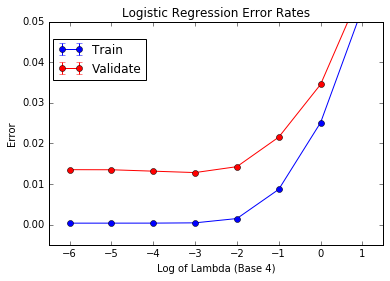

In [10]:
########################################################
# analyze and print plots of the data
########################################################
%matplotlib inline
import matplotlib.pyplot as plt

def get_plot_data(items):
    items.sort(key=lambda x: x[0])
    x, y, var, log_lambda = list(), list(), list(), lambda_exp_min
    for k, v in items:
        x.append(log_lambda)
        y.append(np.mean(v))
        var.append(np.std(v)**2)
        assert lambda_base**log_lambda == k
        log_lambda += 1
    return x, y, var

validate_x, validate_y, validate_v = get_plot_data(list(lambda_to_validate_errors.items()))
train_x, train_y, train_v = get_plot_data(list(lambda_to_training_errors.items()))

plt.errorbar(train_x, train_y, train_v, None, 'bo-', label="Train")
plt.errorbar(validate_x, validate_y, validate_v, None, 'ro-', label="Validate")
plt.axis([lambda_exp_min-.5, lambda_exp_max+.5, -.005, .05])
plt.legend(bbox_to_anchor=(.31,.95))
plt.title("Logistic Regression Error Rates")
plt.xlabel("Log of Lambda (Base {})".format(lambda_base))
plt.ylabel("Error")
plt.show()


In [8]:
########################################################
# Get best weights
########################################################

# pick best lambda
best_lambda = None
min_validate_error = sys.maxsize
for l in lambda_to_validate_errors.keys():
    errs = lambda_to_validate_errors[l]
    err = np.mean(errs)
    if err < min_validate_error:
        min_validate_error = err
        best_lambda = l
print("Best Lambda: {}".format(best_lambda))
        
# test weights
best_weights = None
min_weight_error = sys.maxsize
for w in lambda_to_weights[best_lambda]:
    weight_error = square_loss(all_train_data, int_labels, weights=w)
    if weight_error < min_weight_error:
        min_weight_error = weight_error
        best_weights = w
assert best_weights is not None
print("Best weights have error: {}".format(min_weight_error))
    

Best Lambda: 0.015625
Best weights have error: 0.0017970313261513231


In [9]:
########################################################
# Run on Test Data
########################################################

# get data
test_data = 'test.csv'
test_messages, test_text_labels = read_spam_data(test_data)
test_labels = create_spam_ham_labels(test_text_labels, spam=1, ham=0)

# extract features and test
X_test = train_vectorizer.transform(test_messages).toarray()
test_error = square_loss(X_test, test_labels, weights=best_weights)
print("Error on test data (before tf-idf transform): {}".format(test_error))

# normalize and perform tf-idf
transformer = TfidfTransformer(smooth_idf=False, norm='l2')
tfidf = transformer.fit_transform(X_test)
X_test = tfidf.toarray()
assert X_test.shape[1] == n_features

# test again
test_error = square_loss(X_test, test_labels, weights=best_weights)
print("Error on test data: {}".format(test_error))

Error on test data (before tf-idf transform): 0.017504640023957296


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:993: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


Error on test data: 0.012612299670722879


In [6]:
########################################################
# Extra Credit: Adding in a bias term
########################################################

# because we add in the bias term
n_features_ec = n_features + 1

# create train and validation data sets with bias term
def get_train_data_set_ec(idx):
    t_data, t_labels = list(), list()
    v_data, v_labels = None, None
    for k in all_train_buckets.keys():
        v = all_train_buckets[k]
        if k == idx:
            v_data = v[0]
            v_labels = v[1]
        else:
            t_data.append(v[0])
            t_labels.append(v[1])
    
    t_data = np.vstack(t_data)
    t_data = np.append(np.ones([len(t_data), 1]), t_data, 1)
    t_labels = np.hstack(t_labels)
    v_data = np.append(np.ones([len(v_data), 1]), v_data, 1)
    return {
        TRAIN_DATA: t_data, 
        TRAIN_LABELS: t_labels,  
        VALIDATE_DATA: v_data, 
        VALIDATE_LABELS: v_labels
    }

# get data
all_training_datasets_ec = [get_train_data_set_ec(x) for x in list(range(number_of_buckets))]

# validation
assert len(all_training_datasets_ec) == number_of_buckets
for ds in all_training_datasets_ec:
    assert ds[TRAIN_DATA].shape[1] == n_features_ec
    assert ds[TRAIN_DATA].shape[0] == len(ds[TRAIN_LABELS])
    assert ds[VALIDATE_DATA].shape[1] == n_features_ec
    assert ds[VALIDATE_DATA].shape[0] == len(ds[VALIDATE_LABELS])
    


In [8]:
########################################################
# Extra Credit: Function Redefinition
########################################################

def logistic_regression_ec(inputs, labels, weights, l, alpha, eta_0, step, bias=False, regularization='L2'):
    """Implement regularized logistic regression with moving learning weight"""
    eta = eta_0 * (step ** alpha)
    y_hat = logistic_evaluation(inputs, weights)
    if regularization == 'L2':
        if bias:
            regularize = weights*(eta * l)
            regularize[0] = 0
        else:
            regularize = weights*(eta * l)
    elif regularization == 'L1':
        if bias:
            regularize = np.sign(weights)*(eta * l)
            regularize[0] = 0
        else:
            regularize = np.sign(weights)*(eta * l)
    new_weights = weights - regularize - (eta * np.matmul(np.array(y_hat-labels), inputs))
    return new_weights

def iterative_reweighted_least_squares_ec(inputs, labels, weights, lamda, bias=False):
    """Newton-Raphson iterative reweighted least squares"""
    R, y_hat = logistic_hessian(inputs, weights)
    hessian = np.matmul(np.matmul(inputs.T, R), inputs)
    inv_hessian = np.linalg.pinv(hessian)
    if bias:
        regularize = weights*lamda
        regularize[0] = 0
    else:
        regularize = weights*lamda
    new_weights = weights - np.matmul(inv_hessian, np.matmul(inputs.T, (y_hat - labels)) - regularize)
    return new_weights

def run_regression_ec(lamda, train, train_labels, validate, validate_labels,
                   eta_0=0.1, alpha=0.9, iterations=321, iwlsr=False, bias=True, regularization='L2'):
    # init
    report_frequency = int(iterations / 4)
    t = None
    # run regression
    try:
        weights = np.random.normal(0, 0.2, n_features_ec)
        min_validate_loss = sys.maxsize
        min_train_loss = sys.maxsize
        min_weights_val_loss = []
        for t in range(iterations):
            if iwlsr:
                weights = iterative_reweighted_least_squares_ec(train, train_labels, weights, lamda, bias=bias)
            else:
                weights = logistic_regression_ec(train, train_labels, weights, lamda, alpha, eta_0, t, bias=bias,
                                              regularization=regularization)
            train_loss = square_loss(train, train_labels, weights=weights)
            val_loss = square_loss(validate, validate_labels, weights=weights)
            if val_loss < min_validate_loss: min_weights_val_loss = weights
            if val_loss < min_validate_loss: min_validate_loss = val_loss
            if train_loss < min_train_loss: min_train_loss = train_loss
    except Exception as e:
        print("\nlambda {} #{}: {}".format(lamda, t, e), sys.stderr)
        import traceback
        traceback.print_exc()
        return False
    # return best
    return min_validate_loss, min_train_loss, min_weights_val_loss


In [16]:
########################################################
# Extra Credit: run with bias and L2 regularization
########################################################

# my computer crashed right before this was due as we were finishing this
# but the best result we had was at -6, so I just run that here so we
# can get our final results

# lambda
lambda_base = 4 #8 #np.e
lambda_exp_min = -1 #-5
lambda_exp_max = -1 #1
list_of_lambdas = [lambda_base**i for i in range(lambda_exp_min,lambda_exp_max+1)] 
print("LAMBDAS:\n\tbase: {}   log_min: {}   log_max: {}\n\t{}".format( 
      lambda_base, lambda_exp_min, lambda_exp_max, list_of_lambdas))

# sigmoid params
eta_0 = 0.1
alpha = 0.9


# prep
lambda_to_validate_errors_ec = dict()
lambda_to_training_errors_ec = dict()
lambda_to_weights_ec = dict()

# calculate for our lambdas
for l in list_of_lambdas:
    start = timer()
    print("\nLAMBDA: {} (Extra Credit)\n\t".format(l),end='')
    v_errors = list()
    t_errors = list()
    all_weights = list()
    lambda_to_validate_errors_ec[l] = v_errors
    lambda_to_training_errors_ec[l] = t_errors
    lambda_to_weights_ec[l] = all_weights
    for dataset in all_training_datasets_ec:
        v_error, t_error, weights = run_regression_ec(l, dataset[TRAIN_DATA], dataset[TRAIN_LABELS], 
                       dataset[VALIDATE_DATA], dataset[VALIDATE_LABELS], iwlsr=False, regularization='L2')
        v_errors.append(v_error)
        t_errors.append(t_error)
        all_weights.append(weights)
        print('.', end='')
    print(" ({}s)".format(int(timer() - start)))
    print("\tv errors:    {}".format(v_errors))
    print("\tv error avg: {}".format(np.mean(v_errors)))
    print("\tv error std: {}".format(np.std(v_errors)))

LAMBDAS:
	base: 4   log_min: -1   log_max: -1
	[0.25]

LAMBDA: 0.25 (Extra Credit)
	.......... (269s)
	v errors:    [0.03909078819737923, 0.06833331436527516, 0.035115893852360344, 0.0633333325223199, 0.019933515332367868, 0.0699995262616341, 0.04113338896706907, 0.07668640297708201, 0.07999999998884395, 0.03454377420096687]
	v error avg: 0.052816993666529845
	v error std: 0.020021816895245292


In [10]:
########################################################
# Extra Credit: print table of data
########################################################



size = 13
header = "| %{}s |%{}s |%{}s |%{}s |%{}s |%{}s |".format(size, size, size, size, size, size) % ("log_{}(lambda)".format(lambda_base), "lambda", "val error", "val stddev", "train error", "train stddev")
spacer = "+-" + ("-" * size) + "-+" + ("-" * size) + "-+" + ("-" * size) + "-+" + ("-" * size) + "-+"+ ("-" * size) + "-+"+ ("-" * size) + "-+"
line = "| %{}d |%{}f |%{}f |%{}f |%{}f |%{}f |".format(size, size, size, size, size, size)

print(spacer)
print(header)
print(spacer)
i = lambda_exp_min
for l in list_of_lambdas:
    print(line % (i, l, np.mean(lambda_to_validate_errors_ec[l]), np.std(lambda_to_validate_errors_ec[l]), np.mean(lambda_to_training_errors_ec[l]), np.std(lambda_to_training_errors_ec[l])))
    print(spacer)
    i += 1


+---------------+--------------+--------------+--------------+--------------+--------------+
| log_4(lambda) |       lambda |    val error |   val stddev |  train error | train stddev |
+---------------+--------------+--------------+--------------+--------------+--------------+
|            -6 |     0.000244 |     0.010718 |     0.003857 |     0.000019 |     0.000056 |
+---------------+--------------+--------------+--------------+--------------+--------------+


In [ ]:
########################################################
# Extra Credit: analyze and print plots of the data
########################################################
%matplotlib inline
import matplotlib.pyplot as plt

def get_plot_data(items):
    items.sort(key=lambda x: x[0])
    x, y, var, log_lambda = list(), list(), list(), lambda_exp_min
    for k, v in items:
        x.append(log_lambda)
        y.append(np.mean(v))
        var.append(np.std(v)**2)
        assert lambda_base**log_lambda == k
        log_lambda += 1
    return x, y, var

validate_x, validate_y, validate_v = get_plot_data(list(lambda_to_validate_errors_ec.items()))
train_x, train_y, train_v = get_plot_data(list(lambda_to_training_errors_ec.items()))

plt.errorbar(train_x, train_y, train_v, None, 'bo-', label="Train")
plt.errorbar(validate_x, validate_y, validate_v, None, 'ro-', label="Validate")
plt.axis([lambda_exp_min-.5, lambda_exp_max+.5, -.005, .05])
plt.legend(bbox_to_anchor=(.31,.95))
plt.title("Logistic Regression Error Rates (Extra Credit: bias, L2 regularization)")
plt.xlabel("Log of Lambda (Base {})".format(lambda_base))
plt.ylabel("Error")
plt.show()


In [12]:
########################################################
# Extra Credit: Get best weights
########################################################

# fix all train data
all_train_data_ec = np.append(np.ones([len(all_train_data), 1]), all_train_data, 1)

# pick best lambda
best_lambda_ec = None
min_validate_error_ec = sys.maxsize
for l in lambda_to_validate_errors_ec.keys():
    errs = lambda_to_validate_errors_ec[l]
    err = np.mean(errs)
    if err < min_validate_error_ec:
        min_validate_error_ec = err
        best_lambda_ec = l
print("Best Lambda: {}".format(best_lambda_ec))
        
# test weights
best_weights_ec = None
min_weight_error_ec = sys.maxsize
for w in lambda_to_weights_ec[best_lambda_ec]:
    weight_error = square_loss(all_train_data_ec, int_labels, weights=w)
    if weight_error < min_weight_error_ec:
        min_weight_error_ec = weight_error
        best_weights_ec = w
assert best_weights_ec is not None
print("Best weights have error: {}".format(min_weight_error_ec))

Best Lambda: 0.000244140625
Best weights have error: 0.0010528872197246772


In [15]:
########################################################
# Extra Credit: Run on Test Data
########################################################

# get data
test_data_ec = 'test.csv'
test_messages_ec, test_text_labels_ec = read_spam_data(test_data_ec)
test_labels_ec = create_spam_ham_labels(test_text_labels_ec, spam=1, ham=0)


# extract features, add bias term, test
X_test_ec = train_vectorizer.transform(test_messages_ec).toarray()
X_test_ec = np.append(np.ones([len(X_test_ec), 1]), X_test_ec, 1)
test_error_ec = square_loss(X_test_ec, test_labels_ec, weights=best_weights_ec)
print("Error on test data (before tf-idf transform): {}".format(test_error_ec))

# normalize and perform tf-idf
transformer = TfidfTransformer(smooth_idf=False, norm='l2')
tfidf_ec = transformer.fit_transform(X_test_ec)
X_test_ec = tfidf_ec.toarray()
assert X_test_ec.shape[1] == n_features_ec

# test again
test_error_ec = square_loss(X_test_ec, test_labels_ec, weights=best_weights_ec)
print("Error on test data: {}".format(test_error_ec))

Error on test data (before tf-idf transform): 0.02245931236756499


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:993: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


Error on test data: 0.04861773287481655


## Ham vs Spam: Logistic Regression
##### Andrew Bailey and Trevor Pesout
The task at hand is to classify email headers as either 'spam' or 'ham'. The assumtion is that there are some key words that are in the spam email headers that give them away as spam and by using logistic regression we should be able to classify the difference betwen spam and ham based on the header. 
 ##### _examples:_ 
 
spam - T-Mobile customer you may now claim your FREE CAMERA PHONE upgrade & a pay & go sim card for your loyalty. Call on 0845 021 3680.Offer ends 28thFeb.T&C's apply  
ham  -  Thanks for this hope you had a good day today   
### Natural Language Processing 
We first needed to convert the phrases from the headers of theses emails into a format which is readable by the logistic regression algorithm. 
Some words do not add information such as 'the' and should be removed. Therefore we used the very convenient CountVectorizer class to remove stopwords from all sentences. CountVectorizer also creates an index for each word and vectorizes each input sentence into a count vector. The count vector represents every word in the sentence but it is now in a fixed length vector. In order to normalize the count vector we used TfidfTransformer to weight words by the frequency of their appearance within the entire document. 
$tf(t,d) = $ number of times a term t occurs in document d.  
$n_d$ is the number of documents and $df(d,t)$ is how many documents have term t.
$idf(t,d) = log \frac{n_d}{df(d,t)}+1$ number of times a term t occurs in document d.  
$tfidf(t,d) = tf(t,d)*idf(t,d)$
These counts $tfidf(t,d)$ are then normalized by the Euclidean norm.
Now that we have encoded the sentence information into a vector, we convert the ham and spam labels to 0 and 1 respectively in order to classify each sentence using the logistic regression algorithm.
### Logistic Regression
Now that the inputs have been vectorized, the logistic regression algorithm can be used to determine an optimized weight vector. 
Each sentence is represented by $X = [x_1, x_2, ... x_m]$  
The label of spam or ham is represented by $y \in (0,1)$  
The weight vector is $\mathbf{w} =  [w_1, w_2, ... w_m]$  
The output before the sigmoid function is defined as $a_i = w_0x_0 + w_1x_1 + ... + w_mx_m = \sum_{j=0}^{m} w_j x_j= \mathbf{w}^TX_i$  
Sigmoid function is $\phi(a) = \frac{1}{1 + e^{-a}}$  
Final output is $\phi(a_i) = t_i$
Likelihood  
$L(\mathbf{w}) = P(\mathbf{y} \mid \mathbf{X};\mathbf{w})= \prod_{i=1}^{n} P\big(y^{(i)} \mid X^{(i)}; \mathbf{w}\big)= \prod^{n}_{i=1}\bigg(\phi\big(a^{(i)}\big)\bigg)^{y^{(i)}} \bigg(1-\phi\big(a^{(i)}\big)\bigg)^{1-y^{(i)}}$
Regularization Terms:  
$L2: \frac{\lambda}{2}\lVert \mathbf{w} \lVert_2 = \frac{\lambda}{2} \sum_{j=1}^{m} w_j^2$  
$L1: \lambda\lVert \mathbf{w} \lVert_1 = \lambda \sum_{j=1}^{m} |w_j|$
Objective/Cost Function (Negative Log Likelihood + Regularization)  
$E(w_j) = \sum_{i=1}^{m} \Big[ - y^{(i)} log \bigg( \phi\big(a^{(i)}\big) \bigg) - \big(1 - y^{(i)}\big) log\bigg(1-\phi\big(a^{(i)}\big)\bigg)\Big] - \frac{\lambda}{2} \sum_{j=1}^{m} w_j^2$
Minimize Negative Log Likelihood  
$\begin{align}
\nabla E(w_j) = \frac{\partial}{\partial w_j} l(w_j) &= \sum_{j=1}^{m} \bigg[\bigg(y \frac{1}{\phi(a)} - (1-y) \frac{1}{1-\phi{(a)}} \bigg) \frac{\partial}{\partial w_j}\phi(a) - \frac{\lambda}{2} \frac{\partial}{\partial w_j} w_j^2\bigg] \\ 
&=- \sum_{j=1}^{m} \big(y - \phi(z)\big)x_j - \lambda w_j
\end{align}$
We now have the gradient for the weights and use a decreasing function for the step size $\eta$ in order to decrease the size of the step with each iteration t.
$\begin{align}
\eta &= \eta_0 * t^{-\alpha} \\
\Delta{w_j} & = - \eta \sum_{i=1}^{n}\big(y^{(i)} - \phi\big(z^{(i)}\big) x^{(i)} \big) - \eta \lambda w_j
\end{align}$
We can then turn these gradients into vector representation.
$\begin{align}
\nabla E(\mathbf{w}) = \frac{\partial}{\partial \mathbf{w}} l(\mathbf{w}) &=  - \eta\big(\mathbf{y} - \mathbf{\phi(z)}\big)\mathbf{X}\big) -\mathbf{w}\eta \lambda 
\end{align}$
##### Bias
In order to utilize a bias term the input vector for each sample was prepended with a 1 and the weight vector was not regularized on that term. In order to accomplish this we allowed for a bias regularization option which set the regulzarizers to 0 for that term.  
##### L1 Regularizer 
The L1 term is the sum of the absolute values of all the weights. The partial derivative with respect to the weights of the L1 term is undefined at 0 because the L1 regularizer has a slope of -1 from $-\infty$  to 0 and of 1 from 0 to $\infty$. Thus, when there is a weight with zero we will define the slope as zero.
$\begin{align}
L1: \lambda\lVert \mathbf{w} \lVert_1 &= \lambda \sum_{j=1}^{m} |w_j| \\
\frac{\partial}{\partial w_j} L1(w_j) &=      \begin{cases}
       \lambda &\quad w_j > 0   \\
       0 &\quad w_j = 0 \\
       -\lambda &\quad w_j < 0\\ 
     \end{cases}
\end{align}$
So we can replace the regularization term can be replaced so we update weights using the following equation.   
$\begin{align}
sign(x) &=      \begin{cases}
       1 &\quad x > 0   \\
       0 &\quad x = 0 \\
       -1 &\quad x < 0\\ 
     \end{cases} \\ 
     \Delta{w_j} & = - \eta \sum_{i=1}^{n}\big(y^{(i)} - \phi\big(z^{(i)}\big) x^{(i)} \big) - \eta \lambda sign(w_j)
\end{align}$
### Iterative Least Squares Regression
The update for the iterative reweighted least squares is defined as $\mathbf{w}^{(new)} = \mathbf{w}^{(old)} - \mathbf{H}^{-1}\nabla E(\mathbf{w})$
$
\begin{align}
\nabla E(\mathbf{w}) = \frac{\partial}{\partial \mathbf{w}} l(\mathbf{w}) &=  - \big(\mathbf{y} - \mathbf{\phi(z)}\big)\mathbf{X}\big) -\mathbf{w}\lambda 
\end{align}
$
R is an N X N diagonal matrix with elements $R_{nn} = y_n(1-y_n)$.
$\begin{align}
H &= \nabla \nabla E(\mathbf{w}) = \mathbf{X}^T \mathbf{R} \mathbf{X}
\end{align}$
Therefore the update can be defined as:
$\begin{align}
\mathbf{w}^{(new)} = \mathbf{w}^{(old)} - (\mathbf{X}^T \mathbf{R} \mathbf{X})^{-1} (- \big(\mathbf{y} - \mathbf{\phi(z)}\big)\mathbf{X}\big) -\mathbf{w} \lambda ))
\end{align}
$
### Analysis
###### Bias vs Unbiased
We analyzed the differences between including and excluding a bias term. The validation loss was significantly lower when a bias term was included. This makes sense because a bias term allows us to increase the flexibility of the model to fit the data. 
###### L1 vs L2
We also compared the difference between L1 and L2 regularizer terms. The L1 regularizer directly pulls down all weights towards zero where the L2 regularizer tries to pull the collective squared sum of the weights to zero. There is an obvious difference in the shape of these functions but they both effictively do the same thing. However, the L1 regularizer term allows weights to eventually reach zero where the L2 regularizer does not allow for this behavior. Our results show that, with a bias term, the ######## regularizer fits better. 
###### Iterative Least Squares Regression vs Logistic Regression
The iterative least squares regression algorithm usually requires significantly fewer iterations than the standard logistic regression algorithm. However, the computing the Hessian is very expensive and with a naive python implementation takes much longer to reach the minimum. Also, computing the Hessian requires a batch of data, so there is no natural online method using iterative least squares regression. The least squares regression algorithm also seems to overfit in only a few iterations so there is less room between iterations to find a validation loss minimum.
We found that the steps in ILSR are much too large and overfits the training data before finding a validation local minimum comparable to logistic regression. 
### Results

Unfortunately, as we were finishing our run on the extra credit from lambdas $4^{-6}$ to $4^1$, the computer we were running it on crashed.  So the final results we got for the extra credit are incomplete.  Before it crashed however, we saw that the best lambda had been at $4^{-6}$, so we ran it again with that value and finished our analysis without the plot of lambdas and errors.

Looking at the results between the (original) L1 regularizer with no bias and the (extra credit) L2 regularizer with bias, we get better results on the training data for the latter parameters, and better results on the test data (0.00179 vs 0.00105) with the former parameters (0.0126 vs 0.0486).

This indicates to us that the bias and L2 regularizer caused us to overfit the training data.  We would like to look into this more as we expected the modifications to improve our results, but that is beyond the timeframe of this asisgnment.
